# SVM择时
利用SVM进行择时，目标是识别大趋势的到来

一、标注：<br>
- 判断未来5天涨幅是否大于2%，是则为1，不是则为0 <br>

二、特征：<br>
- 布林特征：价格在距离均线的z-score，识别噪声移动<br>
- macd特征：快慢均线之差，滞后判断趋势<br>
- 价格分位数特征：价格的位置，判断向上的空间<br>

三、模型：<br>
- svc默认rbf

四、结果：<br>
- 样本内68.5%
- 样本外如图

五、结论：<br>
- 样本太少，很玄学

In [30]:
import pandas as pd
import math
# 读取300571.SZ的数据
raw_data = pd.read_csv('./stock_data.csv', index_col = 0)
raw_data = raw_data[raw_data.stock == '300571.SZ']
# 未来5天收盘价变化2%则为正样本，否则为负样本
raw_data['label_long'] = (raw_data.close.shift(-10) / raw_data.close - 1) >= 0.02
raw_data['label_short'] = (raw_data.close.shift(-10) / raw_data.close - 1) <= -0.01
raw_data = raw_data.dropna()

## 特征选取

In [31]:
# 添加均线特征
raw_data['ma5'] = raw_data.close.rolling(5).mean()
raw_data['ma10'] = raw_data.close.rolling(10).mean()
raw_data['ma20'] = raw_data.close.rolling(20).mean()
# 添加乖离率特征
raw_data['bias5'] = (raw_data.close - raw_data.ma5) / raw_data.ma5
raw_data['bias10'] = (raw_data.close - raw_data.ma10) / raw_data.ma10
raw_data['bias20'] = (raw_data.close - raw_data.ma20) / raw_data.ma20
# 添加布林特征
raw_data['boll'] = (raw_data.close - raw_data.ma20) / (2 * raw_data.close.rolling(20).std())
# 添加MACD特征
raw_data['dif'] = raw_data.close.ewm(5).mean() - raw_data.close.ewm(10).mean()
raw_data['dea'] = raw_data.dif.ewm(6).mean()
raw_data['macd'] = 2 * (raw_data.dif - raw_data.dea)
# 添加价格的历史分位数
raw_data['price_rank_1_months'] = raw_data.close.rolling(21).apply(lambda x: x.rank()[-1] / 42)
raw_data['price_rank_2_months'] = raw_data.close.rolling(42).apply(lambda x: x.rank()[-1] / 42)
# 所有特征
features = ['boll', 'macd', 'price_rank_1_months']

In [32]:
# 提取布林特征，macd特征
data = raw_data[features + ['label_long', 'label_short']]
data = data.dropna()
# 标准化
data[features] = (data[features] - data[features].mean()) / data[features].std()
# 分割训练集与测试集
train = data[:int(len(data) * 0.8)]
test = data[int(len(data) * 0.8):]
# 生成训练集和测试集的特征和标签
train_x = train.drop(['label_long', 'label_short'], axis = 1)
train_y_long = train['label_long']
train_y_short = train['label_short']
test_x = test.drop(['label_long', 'label_short'], axis = 1)
test_y_long = test['label_long']
test_y_short = test['label_short']

## 模型训练

In [33]:
# 导入SVM模型
from sklearn import svm
# 建立模型
model_long = svm.SVC()
model_short = svm.SVC()
# 训练模型
model_long.fit(train_x, train_y_long)
model_short.fit(train_x, train_y_short)
# 预测300571.SZ的涨跌
pred_long = model_long.predict(test_x)
pred_short = model_short.predict(test_x)
# 评估
from sklearn.metrics import accuracy_score
print('The accuracy of long signal in sample is ' + str(accuracy_score(test_y_long, pred_long) * 100) + '%.')
print('The accuracy of short signal in sample is ' + str(accuracy_score(test_y_short, pred_short) * 100) + '%.')

The accuracy of long signal in sample is 70.72368421052632%.
The accuracy of short signal in sample is 60.526315789473685%.


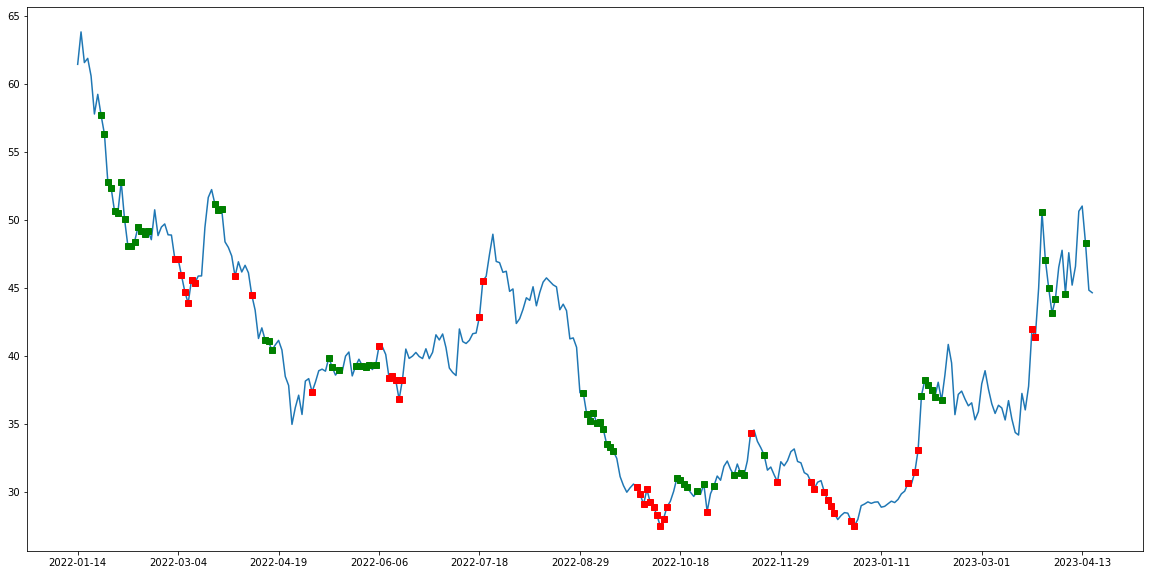

In [34]:
# 根据data中的数据，画出股票k线图
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20, 10))
plt.plot(test_x.index, raw_data['close'][test_x.index])
# 标记预测的买入点
plt.plot(test_x[pred_long == True].index, raw_data['close'][test_x[pred_long == True].index], 'rs')
plt.plot(test_x[pred_short == True].index, raw_data['close'][test_x[pred_short == True].index], 'gs')
my_x_ticks = np.arange(0, len(test_x.index), int(len(test_x.index) / 10))
plt.xticks(my_x_ticks)
plt.show()